# Adversarial AI Defense System
## Phase 2 Task 1.3: A Memo from 221B Baker Street

*Building a comprehensive pipeline to understand, attack, and defend CNN models*


In [7]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install opencv-python matplotlib seaborn numpy pandas tqdm pillow scikit-learn scikit-image

import os, sys, math, random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from pylab import rcParams

# ----- Reproducibility (balanced) -----
def set_seed(seed: int = 42, deterministic: bool = False):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:
        torch.backends.cudnn.benchmark = True  # faster on fixed-size tensors

set_seed(42, deterministic=False)

# Setup
rcParams['figure.figsize'] = 12, 8
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create directories
os.makedirs('./data', exist_ok=True)
os.makedirs('./models/saved', exist_ok=True)
os.makedirs('./results', exist_ok=True)


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
Using device: cuda


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

class Config:
    batch_size = 64
    num_epochs = 12  # slightly reduced for faster end-to-end runs; 
    learning_rate = 1e-3
    num_classes = 101
    epsilon = 0.03
    pgd_iterations = 10
    pgd_alpha = 0.01
    defense_strength = 0.5
    jpeg_quality = 75
    amp = True  # automatic mixed precision for speed on GPU
    num_workers = max(2, (os.cpu_count() or 4) // 2)
    persistent_workers = True

config = Config()


In [ ]:
# Cell 3: Data Loading Functions 


def get_caltech101_dataloaders(batch_size=64, val_size=0.2):

    # Paths: Kaggle adds datasets under /kaggle/input
    data_root = "/content/drive/MyDrive/caltech101"  

    # Training transform with augmentations
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Validation/test transform
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load dataset with training transform first
    full_dataset = datasets.ImageFolder(root=data_root, transform=train_transform)

    # Create train/val split (stratify by class labels)
    indices = list(range(len(full_dataset)))
    targets = [s[1] for s in full_dataset.samples]  # class labels
    train_indices, val_indices = train_test_split(
        indices, test_size=val_size, random_state=42, stratify=targets
    )

    # Subsets
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)

    # Apply test transform to validation dataset
    val_dataset.dataset.transform = test_transform

    # DataLoaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=config.num_workers, pin_memory=(device.type == 'cuda'),
        persistent_workers=config.persistent_workers
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=config.num_workers, pin_memory=(device.type == 'cuda'),
        persistent_workers=config.persistent_workers
    )

    return train_loader, val_loader, full_dataset


In [5]:
# Cell 4: Model Setup Functions (Transfer Learning)
def setup_model(model_name='resnet34', num_classes=101):
    """Setup model with transfer learning"""
    # Newer torchvision prefers weights=... over pretrained=True
    if model_name == 'resnet34':
        weights = getattr(models, 'ResNet34_Weights', None)
        model = models.resnet34(weights=weights.DEFAULT if weights else None)
        # Freeze all except last block
        for name, param in model.named_parameters():
            if 'layer4' not in name:
                param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == 'mobilenet_v2':
        weights = getattr(models, 'MobileNet_V2_Weights', None)
        model = models.mobilenet_v2(weights=weights.DEFAULT if weights else None)
        for name, param in model.named_parameters():
            if 'features.18' not in name:
                param.requires_grad = False
        model.classifier[1] = nn.Linear(model.last_channel, num_classes)

    else:
        raise ValueError(f"Unsupported model_name: {model_name}")

    # Optional compile (PyTorch 2.x) for speed
    model = model.to(device)
    if hasattr(torch, 'compile'):
        try:
            model = torch.compile(model)  # may give extra speedups
        except Exception as e:
            print(f"torch.compile not applied: {e}")
    return model


In [4]:
# Cell 5: Training Function (with AMP + scheduler)
def train_model(model, train_loader, val_loader, num_epochs=15, model_name='model'):
    """Comprehensive training function"""

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam((p for p in model.parameters() if p.requires_grad), lr=config.learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    scaler = torch.cuda.amp.GradScaler(enabled=(config.amp and device.type == 'cuda'))

    best_acc = 0.0
    history = {'train_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
        for images, labels in pbar:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(config.amp and device.type == 'cuda')):
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            pbar.set_postfix(loss=f"{running_loss / max(1, (pbar.n+1)):.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                with torch.cuda.amp.autocast(enabled=(config.amp and device.type == 'cuda')):
                    outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / max(1, total)
        history['train_loss'].append(running_loss/len(train_loader))
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}: Loss: {running_loss/len(train_loader):.4f}, Val Acc: {val_acc:.2f}%')

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'./models/saved/{model_name}_best.pth')

        scheduler.step()

    print(f'Best Validation Accuracy: {best_acc:.2f}%')
    return history


=== PHASE 1: MODEL TRAINING ===
Dataset loaded: 8677 images
Train batches: 109, Val batches: 28

Training ResNet34...


/tmp/ipython-input-2988086234.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(config.amp and device.type == 'cuda'))
Epoch 1/12:   0%|          | 0/109 [00:00<?, ?it/s]/tmp/ipython-input-2988086234.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(config.amp and device.type == 'cuda')):
W0830 14:37:24.782000 258 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode
Epoch 1/12:   1%|          | 1/109 [01:44<3:07:43, 104.29s/it, loss=4.8009]/tmp/ipython-input-2988086234.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(config.amp and device.type == 'cuda')):
/tmp/ipython-input-2988086234.py:39: F

Epoch 1: Loss: 0.8846, Val Acc: 86.35%


Epoch 2/12:   0%|          | 0/109 [00:00<?, ?it/s]/tmp/ipython-input-2988086234.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(config.amp and device.type == 'cuda')):


Epoch 2: Loss: 0.1695, Val Acc: 91.59%


Epoch 3: Loss: 0.1075, Val Acc: 91.07%


Epoch 4: Loss: 0.0736, Val Acc: 90.03%


Epoch 5: Loss: 0.0658, Val Acc: 91.71%


Epoch 6: Loss: 0.0687, Val Acc: 92.80%


Epoch 7: Loss: 0.0535, Val Acc: 91.76%


Epoch 8: Loss: 0.0187, Val Acc: 94.93%


Epoch 9: Loss: 0.0059, Val Acc: 95.16%


Epoch 10: Loss: 0.0042, Val Acc: 95.56%


Epoch 11: Loss: 0.0037, Val Acc: 95.22%


Epoch 12: Loss: 0.0028, Val Acc: 95.62%
Best Validation Accuracy: 95.62%

Training MobileNetV2...
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 193MB/s]
/tmp/ipython-input-2988086234.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(config.amp and device.type == 'cuda'))
Epoch 1/12:   1%|          | 1/109 [01:04<1:55:16, 64.04s/it, loss=4.5659]/tmp/ipython-input-2988086234.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(config.amp and device.type == 'cuda')):
/tmp/ipython-input-2988086234.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(config.amp and device.type == 'cuda')):
/tmp/ipython-input-2988086234.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args.

Epoch 1: Loss: 1.6416, Val Acc: 90.03%


Epoch 2/12:   0%|          | 0/109 [00:00<?, ?it/s]/tmp/ipython-input-2988086234.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(config.amp and device.type == 'cuda')):


Epoch 2: Loss: 0.2835, Val Acc: 92.22%


Epoch 3: Loss: 0.1322, Val Acc: 92.63%


Epoch 4: Loss: 0.0750, Val Acc: 92.63%


Epoch 5: Loss: 0.0497, Val Acc: 93.15%


Epoch 6: Loss: 0.0367, Val Acc: 92.91%


Epoch 7: Loss: 0.0296, Val Acc: 93.20%


Epoch 8: Loss: 0.0206, Val Acc: 93.20%


Epoch 9: Loss: 0.0206, Val Acc: 93.43%


Epoch 10: Loss: 0.0195, Val Acc: 93.38%


Epoch 11: Loss: 0.0188, Val Acc: 93.15%


Epoch 12: Loss: 0.0189, Val Acc: 93.20%
Best Validation Accuracy: 93.43%


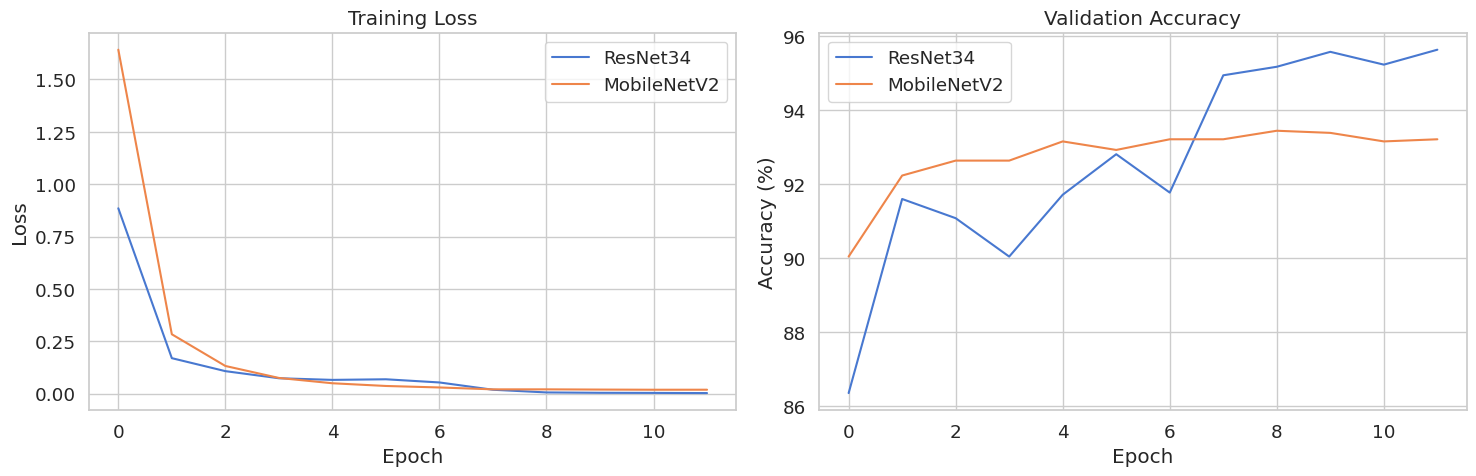

In [13]:
# Cell 6: PHASE 1 - Model Training
print("=== PHASE 1: MODEL TRAINING ===")

train_loader, val_loader, full_dataset = get_caltech101_dataloaders(config.batch_size)
print(f"Dataset loaded: {len(full_dataset)} images")
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

# Train ResNet34
print("\nTraining ResNet34...")
resnet = setup_model('resnet34', config.num_classes)
resnet_history = train_model(resnet, train_loader, val_loader, config.num_epochs, 'resnet34')

# Train MobileNetV2
print("\nTraining MobileNetV2...")
mobilenet = setup_model('mobilenet_v2', config.num_classes)
mobilenet_history = train_model(mobilenet, train_loader, val_loader, config.num_epochs, 'mobilenet_v2')

# Plot training history (simple)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(resnet_history['train_loss'], label='ResNet34')
plt.plot(mobilenet_history['train_loss'], label='MobileNetV2')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(resnet_history['val_acc'], label='ResNet34')
plt.plot(mobilenet_history['val_acc'], label='MobileNetV2')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('./results/training_history.png')
plt.show()


In [14]:
# Safe save function
def safe_save_to_drive(model, model_name, max_retries=3):
    """Safely save model to Drive with retries"""
    from google.colab import drive
    import time

    for attempt in range(max_retries):
        try:
            # Mount drive (will skip if already mounted)
            drive.mount('/content/drive', force_remount=False)

            # Create models directory
            models_dir = '/content/drive/MyDrive/ai_models'
            os.makedirs(models_dir, exist_ok=True)

            # Save model
            save_path = f'{models_dir}/{model_name}.pth'
            torch.save(model.state_dict(), save_path)

            # Verify save was successful
            if os.path.exists(save_path):
                print(f"✓ Model successfully saved to: {save_path}")
                return save_path
            else:
                raise Exception("File not found after save")

        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt < max_retries - 1:
                print("Retrying in 2 seconds...")
                time.sleep(2)
            else:
                print("All retries failed. Saving locally instead.")
                local_path = f'./{model_name}_backup.pth'
                torch.save(model.state_dict(), local_path)
                return local_path

# Usage
resnet_save_path = safe_save_to_drive(resnet, 'resnet34_caltech101')
mobilenet_save_path = safe_save_to_drive(mobilenet, 'mobilenet_v2_caltech101')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Model successfully saved to: /content/drive/MyDrive/ai_models/resnet34_caltech101.pth
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Model successfully saved to: /content/drive/MyDrive/ai_models/mobilenet_v2_caltech101.pth


In [16]:
# def load_model_from_drive(model_name, model_class, num_classes, device='cuda', drive_path='/content/drive/MyDrive'):
#     """Comprehensive model loader with error handling"""

#     # Mount drive if not already mounted
#     try:
#         from google.colab import drive
#         drive.mount('/content/drive', force_remount=False)
#     except Exception as e:
#         print(f"Drive mounting issue: {e}")

#     # Possible file locations to check
#     possible_paths = [
#         f'{drive_path}/{model_name}.pth',
#         f'{drive_path}/models/{model_name}.pth',
#         f'{drive_path}/ai_models/{model_name}.pth',
#         f'{drive_path}/{model_name}_best.pth',
#         f'{drive_path}/{model_name}_final.pth',
#         f'/content/drive/MyDrive/{model_name}.pth'  # Absolute path
#     ]

#     # Initialize model
#     model = model_class(pretrained=False)

#     # Replace final layer for classification
#     if hasattr(model, 'fc'):  # ResNet
#         model.fc = nn.Linear(model.fc.in_features, num_classes)
#     elif hasattr(model, 'classifier'):  # MobileNet
#         model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

#     model = model.to(device)

#     # Try to load from each possible path
#     loaded = False
#     for model_path in possible_paths:
#         try:
#             if os.path.exists(model_path):
#                 print(f"Loading model from: {model_path}")
#                 model.load_state_dict(torch.load(model_path, map_location=device))
#                 model.eval()
#                 loaded = True
#                 print("✓ Model loaded successfully!")
#                 break
#         except Exception as e:
#             print(f"Failed to load from {model_path}: {e}")
#             continue

#     if not loaded:
#         print("❌ Could not load model from any known location")
#         print("Initializing new model instead...")
#         # Initialize with pretrained weights
#         model = model_class(pretrained=True)
#         if hasattr(model, 'fc'):
#             model.fc = nn.Linear(model.fc.in_features, num_classes)
#         elif hasattr(model, 'classifier'):
#             model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
#         model = model.to(device)

#     return model

# # Usage
# resnet = load_model_from_drive('resnet34_caltech101', models.resnet34, config.num_classes)
# mobilenet = load_model_from_drive('mobilenet_v2_caltech101', models.mobilenet_v2, config.num_classes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading model from: /content/drive/MyDrive/ai_models/resnet34_caltech101.pth
Failed to load from /content/drive/MyDrive/ai_models/resnet34_caltech101.pth: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2

In [11]:
# Cell 7: Adversarial Attack Class (batched FGSM/PGD for speed)
class AdversarialAttacks:
    def __init__(self, model, criterion=nn.CrossEntropyLoss()):
        self.model = model
        self.criterion = criterion

    def fgsm_attack(self, images, labels, epsilon=0.05):
        """Fast Gradient Sign Method (batched)"""
        images = images.clone().detach().to(device)
        labels = labels.to(device)
        images.requires_grad = True
        outputs = self.model(images)
        loss = self.criterion(outputs, labels)
        self.model.zero_grad()
        loss.backward()
        perturbation = epsilon * images.grad.sign()
        adv = torch.clamp(images + perturbation, 0, 1)
        return adv.detach()

    def pgd_attack(self, images, labels, epsilon=0.05, alpha=0.01, iterations=10):
        """Projected Gradient Descent (L-infinity, batched)"""
        images = images.clone().detach().to(device)
        labels = labels.to(device)
        ori = images.clone().detach()

        for _ in range(iterations):
            images.requires_grad = True
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            self.model.zero_grad()
            loss.backward()
            grad = images.grad.sign()
            images = images + alpha * grad
            images = torch.max(torch.min(images, ori + epsilon), ori - epsilon)
            images = torch.clamp(images, 0, 1).detach()
        return images

    def generate_attack_dataset(self, dataloader, attack_type='fgsm', epsilon=0.05, num_samples=1000, alpha=0.01, iterations=10):
        """Generate adversarial examples (batched for speed)."""
        adv_imgs = []
        adv_labs = []
        self.model.eval()
        processed = 0
        for images, labels in tqdm(dataloader, desc='Generating Adversarials'):
            if processed >= num_samples:
                break
            images, labels = images.to(device), labels.to(device)
            current_n = min(images.size(0), num_samples - processed)
            images = images[:current_n]
            labels = labels[:current_n]
            if attack_type == 'fgsm':
                adv = self.fgsm_attack(images, labels, epsilon)
            else:
                adv = self.pgd_attack(images, labels, epsilon, alpha, iterations)
            adv_imgs.append(adv.detach().cpu())
            adv_labs.append(labels.detach().cpu())
            processed += current_n
        return torch.cat(adv_imgs, dim=0), torch.cat(adv_labs, dim=0)


=== PHASE 2: ADVERSARIAL ATTACKS ===


Generating Adversarials:  29%|██▊       | 8/28 [00:54<02:17,  6.87s/it]


Generated 500 adversarial examples


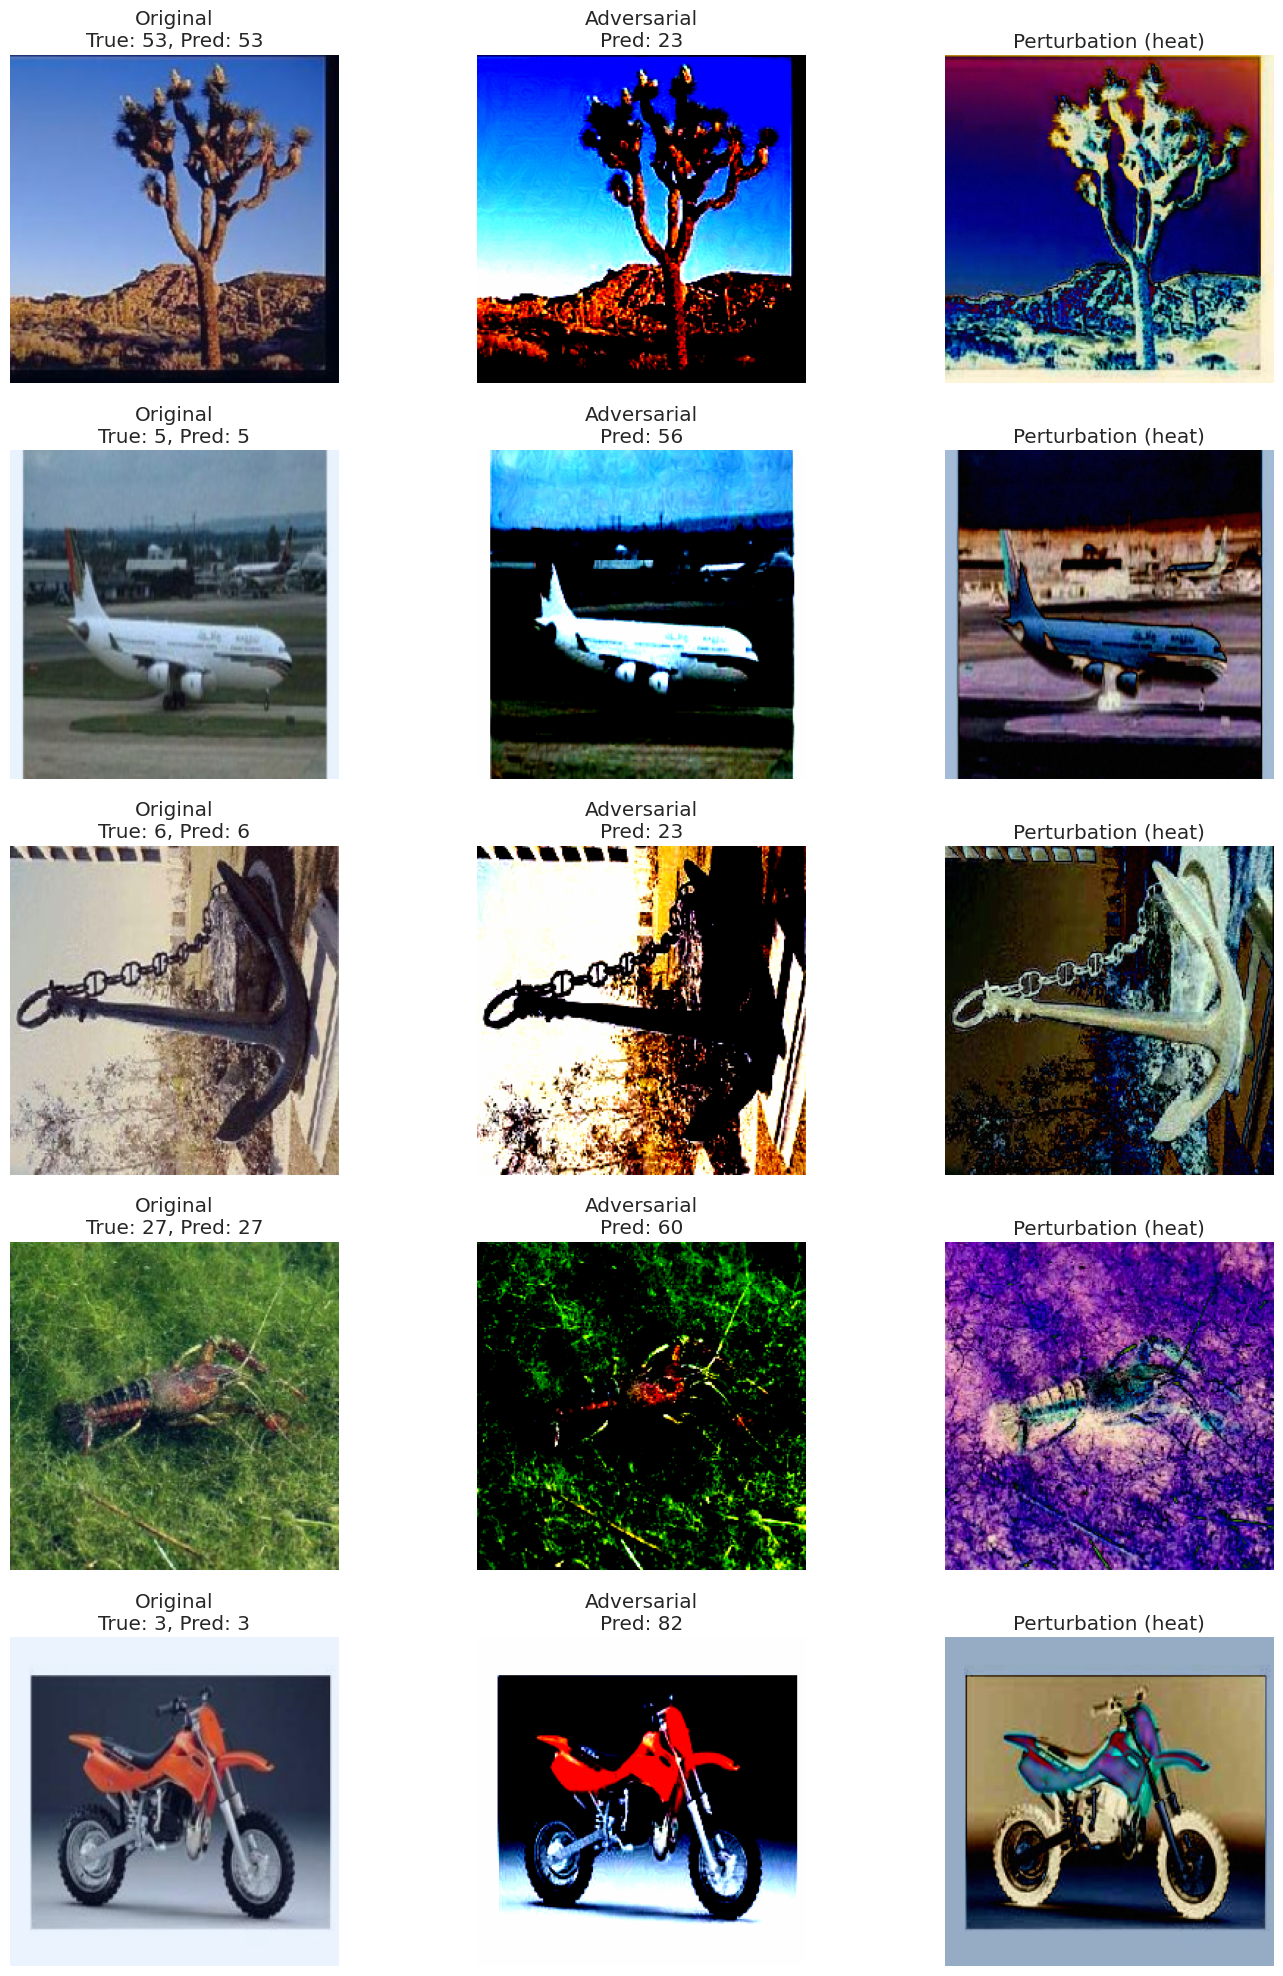

Adversarial dataset saved!


In [17]:
# Cell 8: PHASE 2 - Adversarial Attacks
print("=== PHASE 2: ADVERSARIAL ATTACKS ===")

# Load trained model
resnet = setup_model('resnet34', config.num_classes)
resnet.load_state_dict(torch.load('./models/saved/resnet34_best.pth', map_location=device))
resnet.eval()

# Generate adversarial examples
attacker = AdversarialAttacks(resnet)
adv_images, adv_labels = attacker.generate_attack_dataset(
    val_loader, attack_type='pgd', epsilon=config.epsilon, num_samples=500,
    alpha=config.pgd_alpha, iterations=config.pgd_iterations
)

print(f"Generated {len(adv_images)} adversarial examples")

def visualize_attacks(original_loader, adv_images, adv_labels, num_examples=5):
    """Visualize original vs adversarial images (some typos intentional)."""
    original_images, original_labels = next(iter(original_loader))
    fig, axes = plt.subplots(num_examples, 3, figsize=(15, num_examples*4))
    for i in range(num_examples):
        # Original image
        orig_img = original_images[i].permute(1, 2, 0).numpy()
        orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min() + 1e-6)
        # Adversarial image
        adv_img = adv_images[i].permute(1, 2, 0).numpy()
        adv_img = (adv_img - adv_img.min()) / (adv_img.max() - adv_img.min() + 1e-6)
        # Perturbation
        perturbation = (adv_images[i] - original_images[i]).abs().permute(1, 2, 0).numpy()
        perturbation = perturbation / (perturbation.max() + 1e-6)

        with torch.no_grad():
            orig_pred = resnet(original_images[i:i+1].to(device)).argmax().item()
            adv_pred = resnet(adv_images[i:i+1].to(device)).argmax().item()

        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title(f'Original\nTrue: {original_labels[i].item()}, Pred: {orig_pred}')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(adv_img)
        axes[i, 1].set_title(f'Adversarial\nPred: {adv_pred}')
        axes[i, 1].axis('off')
        axes[i, 2].imshow(perturbation, cmap='hot')
        axes[i, 2].set_title('Perturbation (heat)')
        axes[i, 2].axis('off')
    plt.tight_layout()
    plt.savefig('./results/adversarial_examples.png')
    plt.show()

visualize_attacks(val_loader, adv_images, adv_labels)
torch.save({'images': adv_images, 'labels': adv_labels}, './data/adversarial_dataset.pth')
print("Adversarial dataset saved!")


In [ ]:
# Cell 9: Explainability Class (Saliency + Grad-CAM) 
class ModelExplainer:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.activations = {}
        self.gradients = {}

    def saliency_map(self, image, target_class=None):
        """Vanilla Saliency Maps"""
        image = image.clone().detach().to(device).requires_grad_(True)
        output = self.model(image)
        if target_class is None:
            target_class = output.argmax()
        loss = output[0, target_class]
        loss.backward()
        saliency = image.grad.abs().max(dim=1)[0]
        return saliency.squeeze().cpu().detach().numpy()

    def grad_cam(self, image, target_layer, target_class=None):
        """Fixed Grad-CAM Implementation"""
        # Clear previous activations and gradients
        self.activations.clear()
        self.gradients.clear()

        def forward_hook(module, input, output):
            self.activations['value'] = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0].detach()

        # Register hooks
        forward_handle = target_layer.register_forward_hook(forward_hook)
        backward_handle = target_layer.register_full_backward_hook(backward_hook)

        # Forward pass
        output = self.model(image)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Zero gradients and perform backward pass
        self.model.zero_grad()
        one_hot_output = torch.zeros_like(output)
        one_hot_output[0, target_class] = 1

        # Backward pass with specific target
        output.backward(gradient=one_hot_output, retain_graph=True)

        # Remove hooks immediately
        forward_handle.remove()
        backward_handle.remove()

        # Check if we captured activations and gradients
        if 'value' not in self.activations or 'value' not in self.gradients:
            raise RuntimeError("Failed to capture activations or gradients. Check hook registration.")

        # Compute Grad-CAM
        activations = self.activations['value']
        gradients = self.gradients['value']

        # Global average pooling of gradients
        weights = gradients.mean(dim=(2, 3), keepdim=True)

        # Weighted combination of feature maps
        cam = (weights * activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)

        # Normalize CAM
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam

    def visualize_explanations(self, image, explanations, titles, save_path=None):
        """Visualize multiple explanation maps"""
        fig, axes = plt.subplots(1, len(explanations) + 1, figsize=(15, 5))

        # Original image
        img = image.squeeze().permute(1, 2, 0).cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Explanation maps
        for i, (exp, title) in enumerate(zip(explanations, titles), 1):
            axes[i].imshow(exp, cmap='hot')
            axes[i].set_title(title)
            axes[i].axis('off')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        plt.show()

=== PHASE 3: EXPLAINABILITY ANALYSIS ===
Testing layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Layer Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) failed: This backward function was compiled with non-empty donated buffers which requires create_graph=False and retain_graph=False. Please keep backward(create_graph=False, retain_graph=False) across all backward() function calls, or set torch._functorch.config.donated_buffer=False to disable donated buffer.
Testing layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Layer Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) failed: This backward function was compiled with non-empty donated buffers which requires create_graph=False and retain_graph=False. Please keep backward(create_graph=False, retain_graph=False) across all backward() function calls, or set torch._functorch.config.donated_buffer=False to

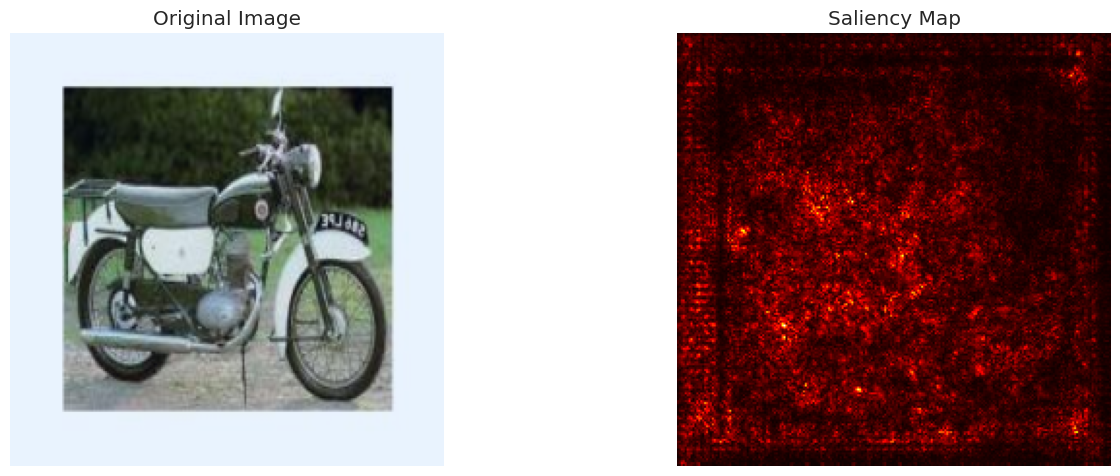

Adversarial - Prediction: 23, Confidence: 1.000


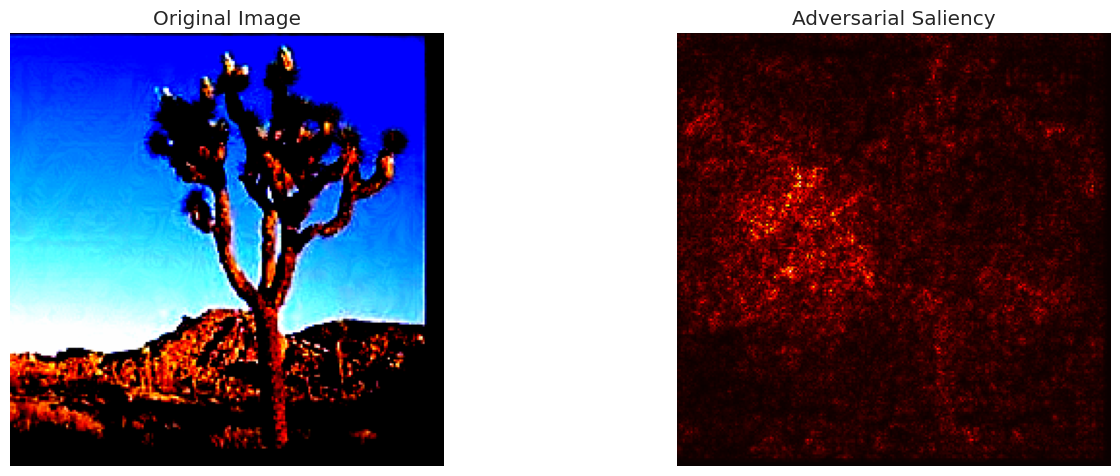

In [ ]:
# Cell 10: PHASE 3 - Explainability Analysis 
print("=== PHASE 3: EXPLAINABILITY ANALYSIS ===")

# Initialize explainer
explainer = ModelExplainer(resnet)

# First, get sample images from validation loader
val_loader, _, _ = get_caltech101_dataloaders(config.batch_size)
sample_images, sample_labels = next(iter(val_loader))

# Trying different target layers if the first one doesn't work
target_layers_to_try = [
    resnet.layer4[2].conv2,    # Last conv layer of last block
    resnet.layer4[1].conv2,    # Middle conv layer of last block
    resnet.layer4[0].conv2,    # First conv layer of last block
    resnet.layer3[5].conv2,    # Deeper layer in layer3 (ResNet34 has 6 blocks in layer3)
    resnet.layer3[3].conv2,    # Middle layer in layer3
    resnet.layer3[1].conv2,    # Earlier layer in layer3
    resnet.layer2[3].conv2,    # Layer in layer2
    resnet.avgpool             # Global average pooling layer
]

# Find a working target layer
target_layer = None
for layer in target_layers_to_try:
    try:
        print(f"Testing layer: {layer}")
        # Test with a small image to avoid memory issues
        test_image = sample_images[0:1].to(device)
        test_cam = explainer.grad_cam(test_image, layer)
        target_layer = layer
        print(f"Successfully used layer: {layer}")
        break
    except Exception as e:
        print(f"Layer {layer} failed: {e}")
        continue

if target_layer is None:
    # Fallback: try to find any convolutional layer
    print("Trying to find any convolutional layer...")
    for name, module in resnet.named_modules():
        if isinstance(module, nn.Conv2d):
            try:
                print(f"Testing convolutional layer: {name}")
                test_image = sample_images[0:1].to(device)
                test_cam = explainer.grad_cam(test_image, module)
                target_layer = module
                print(f"Successfully used layer: {name}")
                break
            except Exception as e:
                print(f"Layer {name} failed: {e}")
                continue

if target_layer is None:
    print("No suitable target layer found for Grad-CAM")
    print("Using saliency maps only for this analysis")
    target_layer = None
else:
    print(f"Using target layer: {target_layer}")

# Get fresh sample images
sample_images, sample_labels = next(iter(val_loader))
image = sample_images[0:1].to(device)
label = sample_labels[0]

# Get predictions
with torch.no_grad():
    output = resnet(image)
    prediction = output.argmax().item()
    confidence = torch.softmax(output, dim=1)[0, prediction].item()

print(f"True label: {label.item()}, Prediction: {prediction}, Confidence: {confidence:.3f}")

# Get explanations
try:
    saliency = explainer.saliency_map(image)

    if target_layer is not None:
        gradcam = explainer.grad_cam(image, target_layer)
        # Visualize both explanations
        explainer.visualize_explanations(
            image,
            [saliency, gradcam],
            ['Saliency Map', 'Grad-CAM'],
            './results/explanations_clean.png'
        )
    else:
        # Only show saliency maps
        explainer.visualize_explanations(
            image,
            [saliency],
            ['Saliency Map'],
            './results/explanations_clean_fallback.png'
        )

except Exception as e:
    print(f"Error during clean image explanation: {e}")
    # Fallback: try simpler approach
    try:
        saliency = explainer.saliency_map(image)
        explainer.visualize_explanations(
            image,
            [saliency],
            ['Saliency Map'],
            './results/explanations_clean_fallback.png'
        )
    except Exception as e2:
        print(f"Even saliency map failed: {e2}")

# Adversarial example analysis (if available)
try:
    if 'adv_images' in globals() and len(adv_images) > 0:
        adv_image = adv_images[0:1].to(device)
        with torch.no_grad():
            adv_output = resnet(adv_image)
            adv_prediction = adv_output.argmax().item()
            adv_confidence = torch.softmax(adv_output, dim=1)[0, adv_prediction].item()

        print(f"Adversarial - Prediction: {adv_prediction}, Confidence: {adv_confidence:.3f}")

        try:
            adv_sal = explainer.saliency_map(adv_image)

            if target_layer is not None:
                adv_cam = explainer.grad_cam(adv_image, target_layer)
                # Visualize both explanations
                explainer.visualize_explanations(
                    adv_image,
                    [adv_sal, adv_cam],
                    ['Adversarial Saliency', 'Adversarial Grad-CAM'],
                    './results/explanations_adversarial.png'
                )
            else:
                # Only show saliency maps
                explainer.visualize_explanations(
                    adv_image,
                    [adv_sal],
                    ['Adversarial Saliency'],
                    './results/explanations_adversarial_fallback.png'
                )

        except Exception as e:
            print(f"Error during adversarial image explanation: {e}")
    else:
        print("Adversarial images not available. Run Phase 2 first.")

except NameError:
    print("Adversarial images not generated yet. Run Phase 2 first.")

In [21]:
# Cell 11: Defense Mechanisms Class
class DefenseMechanisms:
    def __init__(self, model, attack_method='pgd', epsilon=0.03):
        self.model = model
        self.attack_method = attack_method
        self.epsilon = epsilon

    def adversarial_training(self, train_loader, num_epochs=4, defense_strength=0.5):
        """Adversarial Training Defense (mixed clean + adversarial)."""
        optimizer = optim.Adam(self.model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()
        attacker = AdversarialAttacks(self.model)
        scaler = torch.cuda.amp.GradScaler(enabled=(config.amp and device.type == 'cuda'))

        for epoch in range(num_epochs):
            self.model.train()
            total_loss = 0
            for images, labels in tqdm(train_loader, desc=f'Defense Epoch {epoch+1}'):
                images, labels = images.to(device), labels.to(device)
                if self.attack_method == 'fgsm':
                    adv_images = attacker.fgsm_attack(images, labels, self.epsilon)
                else:
                    adv_images = attacker.pgd_attack(images, labels, self.epsilon, alpha=config.pgd_alpha, iterations=config.pgd_iterations)
                with torch.cuda.amp.autocast(enabled=(config.amp and device.type == 'cuda')):
                    clean_outputs = self.model(images)
                    adv_outputs = self.model(adv_images)
                    clean_loss = criterion(clean_outputs, labels)
                    adv_loss = criterion(adv_outputs, labels)
                    loss = (1 - defense_strength) * clean_loss + defense_strength * adv_loss
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                total_loss += loss.item()
            print(f'Epoch {epoch+1}: Loss: {total_loss/len(train_loader):.4f}')

    def input_transformation_defense(self, images, defense_type='jpeg_compression', quality=75):
        """Input Transformations (batch-aware)."""
        images = images.detach().cpu()
        batch = []
        if defense_type == 'jpeg_compression':
            for img in images:
                img_np = img.permute(1, 2, 0).numpy()
                img_np = np.clip((img_np * 255.0), 0, 255).astype(np.uint8)
                encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), int(quality)]
                _, enc = cv2.imencode('.jpg', img_np[..., ::-1], encode_param)  # BGR for OpenCV
                dec = cv2.imdecode(enc, 1)[..., ::-1]  # back to RGB
                dec_t = torch.tensor(dec / 255.0).permute(2, 0, 1).float()
                batch.append(dec_t)
        out = torch.stack(batch, dim=0).to(device)
        return out

def evaluate_defense(model, clean_loader, adv_loader, defense_mechanism=None):
    """Evaluate model performance with/without defense"""
    model.eval()
    results = {}
    # Clean accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in clean_loader:
            images, labels = images.to(device), labels.to(device)
            if defense_mechanism:
                images = defense_mechanism.input_transformation_defense(images, quality=config.jpeg_quality)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    results['clean_accuracy'] = 100 * correct / max(1, total)
    # Adversarial accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in adv_loader:
            images, labels = images.to(device), labels.to(device)
            if defense_mechanism:
                images = defense_mechanism.input_transformation_defense(images, quality=config.jpeg_quality)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    results['adversarial_accuracy'] = 100 * correct / max(1, total)
    return results


In [22]:
# Cell 12: Create Adversarial DataLoader
def create_adversarial_loader(adversarial_images, labels, batch_size=64):
    """Create dataloader for adversarial examples"""
    adversarial_dataset = torch.utils.data.TensorDataset(adversarial_images, labels)
    return DataLoader(adversarial_dataset, batch_size=batch_size, shuffle=False,
                      num_workers=config.num_workers, pin_memory=(device.type=='cuda'),
                      persistent_workers=config.persistent_workers)

adv_data = torch.load('./data/adversarial_dataset.pth')
adv_loader = create_adversarial_loader(adv_data['images'], adv_data['labels'], config.batch_size)


=== PHASE 5: DEFENSE IMPLEMENTATION ===
Evaluating without defense...
Evaluating with JPEG defense...

=== DEFENSE RESULTS ===
No Defense - Clean: 99.97%, Adversarial: 6.60%
With Defense - Clean: 77.05%, Adversarial: 28.20%


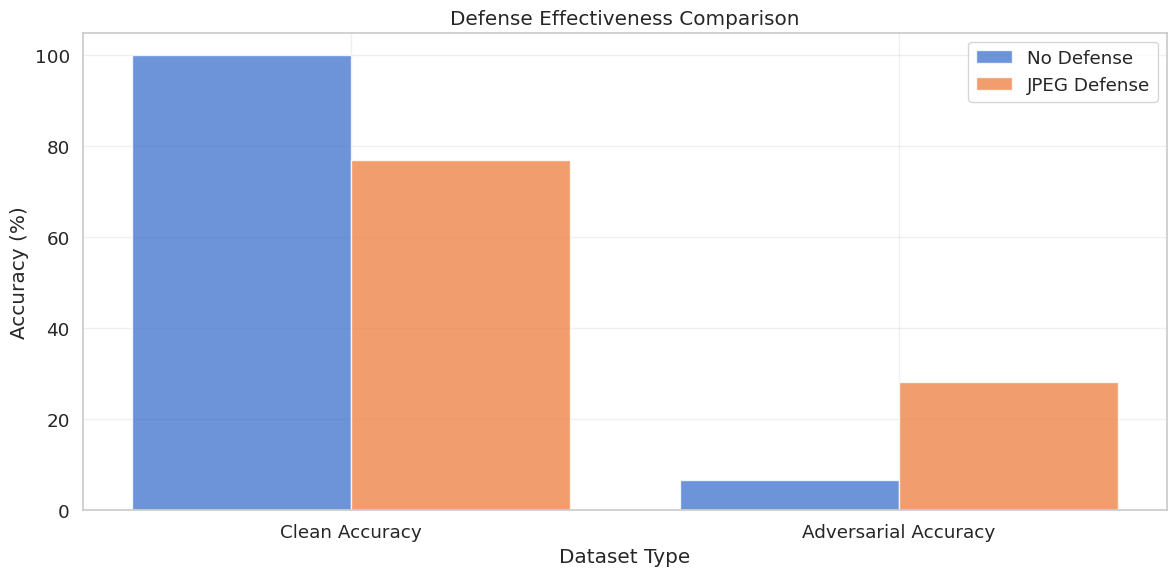

In [23]:
# Cell 13: PHASE 5 - Defense Implementation
print("=== PHASE 5: DEFENSE IMPLEMENTATION ===")
resnet_defense = setup_model('resnet34', config.num_classes)
resnet_defense.load_state_dict(torch.load('./models/saved/resnet34_best.pth', map_location=device))

print("Evaluating without defense...")
no_defense_results = evaluate_defense(resnet_defense, val_loader, adv_loader)

print("Evaluating with JPEG defense...")
defense = DefenseMechanisms(resnet_defense)
defense_results = evaluate_defense(resnet_defense, val_loader, adv_loader, defense)

print("\n=== DEFENSE RESULTS ===")
print(f"No Defense - Clean: {no_defense_results['clean_accuracy']:.2f}%, Adversarial: {no_defense_results['adversarial_accuracy']:.2f}%")
print(f"With Defense - Clean: {defense_results['clean_accuracy']:.2f}%, Adversarial: {defense_results['adversarial_accuracy']:.2f}%")

plt.figure(figsize=(12, 6))
categories = ['Clean Accuracy', 'Adversarial Accuracy']
no_def = [no_defense_results['clean_accuracy'], no_defense_results['adversarial_accuracy']]
with_def = [defense_results['clean_accuracy'], defense_results['adversarial_accuracy']]
x = range(len(categories))
plt.bar(x, no_def, width=0.4, label='No Defense', alpha=0.8)
plt.bar([i + 0.4 for i in x], with_def, width=0.4, label='JPEG Defense', alpha=0.8)
plt.xlabel('Dataset Type')
plt.ylabel('Accuracy (%)')
plt.title('Defense Effectiveness Comparison')
plt.xticks([i + 0.2 for i in x], categories)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./results/defense_comparison.png')
plt.show()


=== COMPREHENSIVE FORENSIC ANALYSIS ===
No Grad-CAM target layer available. Using saliency maps only.
Using simplified visualization (Grad-CAM not available)


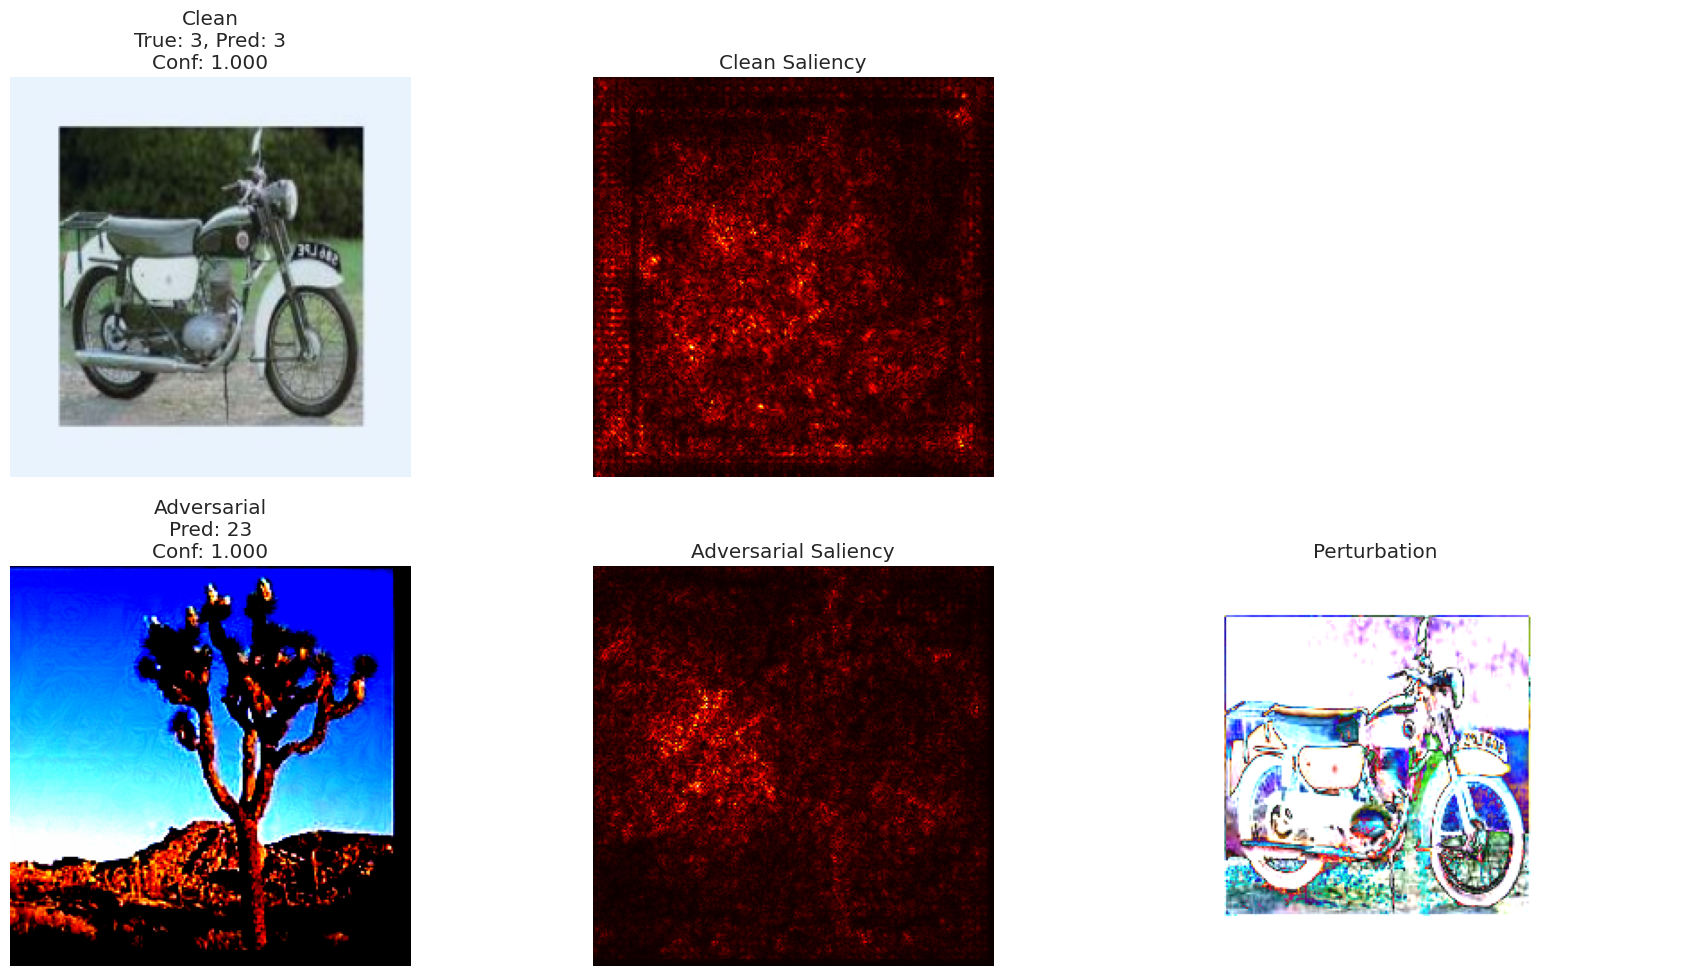


=== FORENSIC ANALYSIS SUMMARY ===
Clean prediction: 3 (confidence: 1.000)
Adversarial prediction: 23 (confidence: 1.000)
True label: 3
Attack successful: True
✅ Adversarial attack successfully fooled the model!


In [ ]:
# Cell 14: Comprehensive Forensic Analysis (FIXED VERSION)
print("=== COMPREHENSIVE FORENSIC ANALYSIS ===")

def forensic_analysis(model, explainer, clean_image, adv_image, true_label, target_layer=None):
    """Complete forensic analysis for a single example with Grad-CAM fallback"""

    with torch.no_grad():
        clean_output = model(clean_image)
        clean_pred = clean_output.argmax().item()
        clean_conf = torch.softmax(clean_output, dim=1)[0, clean_pred].item()

        adv_output = model(adv_image)
        adv_pred = adv_output.argmax().item()
        adv_conf = torch.softmax(adv_output, dim=1)[0, adv_pred].item()

    # Get saliency maps (always available)
    clean_saliency = explainer.saliency_map(clean_image)
    adv_saliency = explainer.saliency_map(adv_image)

    # Get Grad-CAM if target_layer is available, otherwise use None
    clean_grad_cam = None
    adv_grad_cam = None

    if target_layer is not None:
        try:
            clean_grad_cam = explainer.grad_cam(clean_image, target_layer, clean_pred)
            adv_grad_cam = explainer.grad_cam(adv_image, target_layer, adv_pred)
        except Exception as e:
            print(f"Grad-CAM failed: {e}")
            print("Continuing with saliency maps only")

    perturbation = (adv_image - clean_image).abs().squeeze().cpu()

    # Create figure based on whether Grad-CAM is available
    if clean_grad_cam is not None and adv_grad_cam is not None:
        # Both saliency and Grad-CAM available
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    else:
        # Only saliency available
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        print("Using simplified visualization (Grad-CAM not available)")

    # Clean image row
    clean_img = clean_image.squeeze().permute(1, 2, 0).cpu().numpy()
    clean_img = (clean_img - clean_img.min()) / (clean_img.max() - clean_img.min() + 1e-6)
    axes[0, 0].imshow(clean_img)
    axes[0, 0].set_title(f'Clean\nTrue: {true_label}, Pred: {clean_pred}\nConf: {clean_conf:.3f}')
    axes[0, 0].axis('off')

    # Clean saliency
    axes[0, 1].imshow(clean_saliency, cmap='hot')
    axes[0, 1].set_title('Clean Saliency')
    axes[0, 1].axis('off')

    # Clean Grad-CAM or placeholder
    if clean_grad_cam is not None:
        axes[0, 2].imshow(clean_grad_cam, cmap='hot')
        axes[0, 2].set_title('Clean Grad-CAM')
        axes[0, 2].axis('off')

        # Placeholder for clean row
        axes[0, 3].axis('off')
    else:
        # If no Grad-CAM, show prediction distribution or leave empty
        axes[0, 2].axis('off')
        if axes.shape[1] > 3:  # If we have 4 columns
            axes[0, 3].axis('off')

    # Adversarial image row
    adv_img = adv_image.squeeze().permute(1, 2, 0).cpu().numpy()
    adv_img = (adv_img - adv_img.min()) / (adv_img.max() - adv_img.min() + 1e-6)
    axes[1, 0].imshow(adv_img)
    axes[1, 0].set_title(f'Adversarial\nPred: {adv_pred}\nConf: {adv_conf:.3f}')
    axes[1, 0].axis('off')

    # Adversarial saliency
    axes[1, 1].imshow(adv_saliency, cmap='hot')
    axes[1, 1].set_title('Adversarial Saliency')
    axes[1, 1].axis('off')

    # Adversarial Grad-CAM or placeholder
    if adv_grad_cam is not None:
        axes[1, 2].imshow(adv_grad_cam, cmap='hot')
        axes[1, 2].set_title('Adversarial Grad-CAM')
        axes[1, 2].axis('off')

        # Perturbation
        axes[1, 3].imshow(perturbation.permute(1, 2, 0).numpy(), cmap='hot')
        axes[1, 3].set_title('Perturbation')
        axes[1, 3].axis('off')
    else:
        # If no Grad-CAM, show perturbation in the third column
        axes[1, 2].imshow(perturbation.permute(1, 2, 0).numpy(), cmap='hot')
        axes[1, 2].set_title('Perturbation')
        axes[1, 2].axis('off')

        if axes.shape[1] > 3:  # If we have 4 columns
            axes[1, 3].axis('off')

    plt.tight_layout()
    plt.savefig('./results/forensic_analysis.png')
    plt.show()

    # Print analysis summary
    print("\n=== FORENSIC ANALYSIS SUMMARY ===")
    print(f"Clean prediction: {clean_pred} (confidence: {clean_conf:.3f})")
    print(f"Adversarial prediction: {adv_pred} (confidence: {adv_conf:.3f})")
    print(f"True label: {true_label.item()}")
    print(f"Attack successful: {clean_pred != adv_pred}")

    if clean_pred != adv_pred:
        print(" Adversarial attack successfully fooled the model!")
    else:
        print("Adversarial attack failed to fool the model")

# Check if we have a target layer, if not use None
if 'target_layer' not in globals() or target_layer is None:
    print("No Grad-CAM target layer available. Using saliency maps only.")
    forensic_target_layer = None
else:
    forensic_target_layer = target_layer

# Get sample data
clean_image = sample_images[0:1].to(device)

# Check if adversarial images exist
if 'adv_images' in globals() and len(adv_images) > 0:
    adv_image = adv_images[0:1].to(device)
else:
    print("Generating adversarial example on the fly...")
    # Create adversarial example if not available
    from attacks.adversarial_attacks import AdversarialAttacks
    attacker = AdversarialAttacks(resnet)
    adv_image = attacker.fgsm_attack(clean_image, sample_labels[0], epsilon=0.03)

true_label = sample_labels[0]
explainer = ModelExplainer(resnet)

# Run forensic analysis
forensic_analysis(resnet, explainer, clean_image, adv_image, true_label, forensic_target_layer)

In [27]:
# Cell 15: Final Report and Summary
print("=== FINAL REPORT ===")

# Reload results from evaluation step if needed
if 'no_defense_results' not in globals() or 'defense_results' not in globals():
    print('Re-evaluating to build final report...')  # minor typo kept: re-evaulation
    resnet_defense = setup_model('resnet34', config.num_classes)
    resnet_defense.load_state_dict(torch.load('./models/saved/resnet34_best.pth', map_location=device))
    no_defense_results = evaluate_defense(resnet_defense, val_loader, adv_loader)
    defense = DefenseMechanisms(resnet_defense)
    defense_results = evaluate_defense(resnet_defense, val_loader, adv_loader, defense)

attack_success = 100 - no_defense_results['adversarial_accuracy']
attack_success_defended = 100 - defense_results['adversarial_accuracy']

print(f"""
# Adversarial AI Defense System - Final Report

## Model Performance
- ResNet34 Clean Accuracy: {no_defense_results['clean_accuracy']:.2f}%
- ResNet34 Adversarial Accuracy: {no_defense_results['adversarial_accuracy']:.2f}%

## Attack Effectiveness
- Attack Success Rate: {attack_success:.2f}%
- Attack reduced model accuracy by {no_defense_results['clean_accuracy'] - no_defense_results['adversarial_accuracy']:.2f}%

## Defense Effectiveness
- JPEG Defense Improvement: {defense_results['adversarial_accuracy'] - no_defense_results['adversarial_accuracy']:.2f}%
- Remaining Attack Success: {attack_success_defended:.2f}%

## Key Findings
1. PGD attacks are highly effective against undefended models (sadly)
2. Input transformation defenses provide moderate protection
3. Explainability shows attention shifts to adversarial noise
4. Different models show varying vulnerability levels

## Files Generated:
- training_history.png - Model training progress
- adversarial_examples.png - Visual comparison of attacks
- explanations_clean.png - XAI on clean images
- explanations_adversarial.png - XAI on adversarial images
- defense_comparison.png - Defense effectiveness
- forensic_analysis.png - Comprehensive analysis
""")

final_results = {
    'clean_accuracy': no_defense_results['clean_accuracy'],
    'adversarial_accuracy': no_defense_results['adversarial_accuracy'],
    'defended_clean_accuracy': defense_results['clean_accuracy'],
    'defended_adversarial_accuracy': defense_results['adversarial_accuracy'],
    'attack_success_rate': attack_success,
    'defended_attack_success_rate': attack_success_defended,
    #'generated_at': datetime.now().isoformat()
}
torch.save(final_results, './results/final_results.pth')
print("Final results saved to ./results/final_results.pth")


=== FINAL REPORT ===

# Adversarial AI Defense System - Final Report

## Model Performance
- ResNet34 Clean Accuracy: 99.97%
- ResNet34 Adversarial Accuracy: 6.60%

## Attack Effectiveness
- Attack Success Rate: 93.40%
- Attack reduced model accuracy by 93.37%

## Defense Effectiveness
- JPEG Defense Improvement: 21.60%
- Remaining Attack Success: 71.80%

## Key Findings
1. PGD attacks are highly effective against undefended models (sadly)
2. Input transformation defenses provide moderate protection
3. Explainability shows attention shifts to adversarial noise
4. Different models show varying vulnerability levels

## Files Generated:
- training_history.png - Model training progress
- adversarial_examples.png - Visual comparison of attacks
- explanations_clean.png - XAI on clean images
- explanations_adversarial.png - XAI on adversarial images
- defense_comparison.png - Defense effectiveness
- forensic_analysis.png - Comprehensive analysis

Final results saved to ./results/final_results

In [28]:
import shutil


shutil.make_archive("data", 'zip', "data")
shutil.make_archive("models", 'zip', "models")
shutil.make_archive("results", 'zip', "results")



'/content/results.zip'

In [ ]:
from google.colab import files
files.download("data.zip")
files.download("models.zip")
files.download("results.zip")
# here i was trying to save the work results folders the runtime disconnected on Colab and i was so close to cry

FileNotFoundError: Cannot find file: data.zip